In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as spo
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.optimize import differential_evolution
import scipy.integrate as spi

In [ ]:
T = [4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 16.5, 17, 17.5, 18]

In [36]:
df = pd.read_csv('data/data.csv')

In [37]:
df.head()

,H,T1,H2,T2,H3,T3,h,t1,h2,t2,h3,t3
0,4.0,76.94587,4.0,78.84852,4.0,84.64570,4.0,1.00000,4.0,1.00000,4.0,1.00000
1,5.0,63.93416,5.0,65.64488,5.0,68.16495,5.0,0.83090,5.0,0.83254,5.0,0.80530
2,6.0,53.51895,6.0,55.20996,6.0,60.39511,6.0,0.69554,6.0,0.70020,6.0,0.71350
3,7.0,46.60465,7.0,52.21923,7.0,54.03687,7.0,0.60568,7.0,0.66227,7.0,0.63839
4,8.0,40.74063,8.0,45.28438,8.0,47.02712,8.0,0.52947,8.0,0.57432,8.0,0.55558


In [38]:
T = df['H']
t = df['h']

In [39]:
H1 = df['T1']
H2 = df['T2']
H3 = df['T3']

h1 = df['t1']
h2 = df['t2']
h3 = df['t3']

In [40]:
H = H1 + H2 + H3 / 3
h = h1 + h2 + h3 / 3

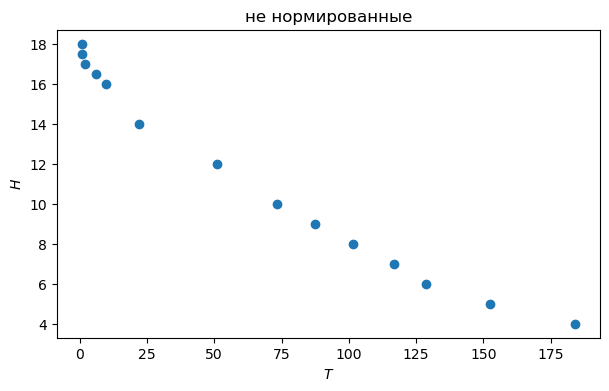

In [41]:
plt.figure(figsize=(7, 4))
plt.scatter(H, T)
plt.xscale("linear")
# plt.yscale("log")
plt.xlabel(r'$T$')
plt.ylabel(r'$H$')
plt.title(r'не нормированные')
plt.show()

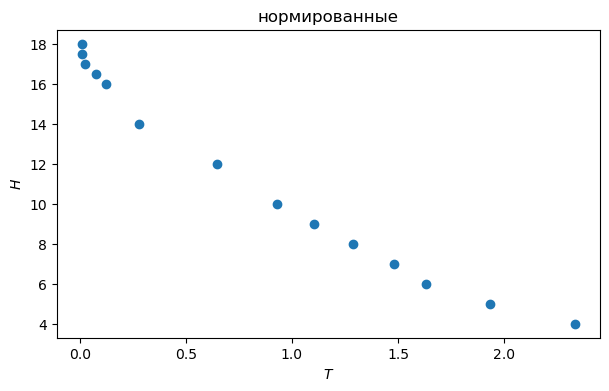

In [42]:
plt.figure(figsize=(7, 4))
plt.scatter(h, t)
plt.xscale("linear")
# plt.yscale("log")
plt.xlabel(r'$T$')
plt.ylabel(r'$H$')
plt.title(r'нормированные')
plt.show()

$ H_c(T) = H_c(0) (1 - \dfrac{T}{T_c}) $

In [43]:
def compute_Hc(T, Tc, H0):
    return H0 * (1 - T/Tc)

In [44]:
def loss_function(params, H, T):
    H0, Tc = params
    Hc = compute_Hc(T, Tc, H0)
    return np.mean((H - Hc) ** 2)

In [45]:
initial_params = [10, 10]
bounds = [
    (0, 1e9),
    (0, 1e9),
]  # Границы для оптимизации

In [ ]:
result = minimize(loss_function, initial_params, args=(H, T),
                  bounds=bounds, method="Nelder-Mead")

In [47]:
result = differential_evolution(loss_function, bounds, args=(H, T))

In [48]:
H0_opt, Tc_opt = result.x
print(
    f"Оптимальные параметры: H0={H0_opt}, Tc={Tc_opt}")

Оптимальные параметры: H0=66.8952844822074, Tc=667330311.4637005


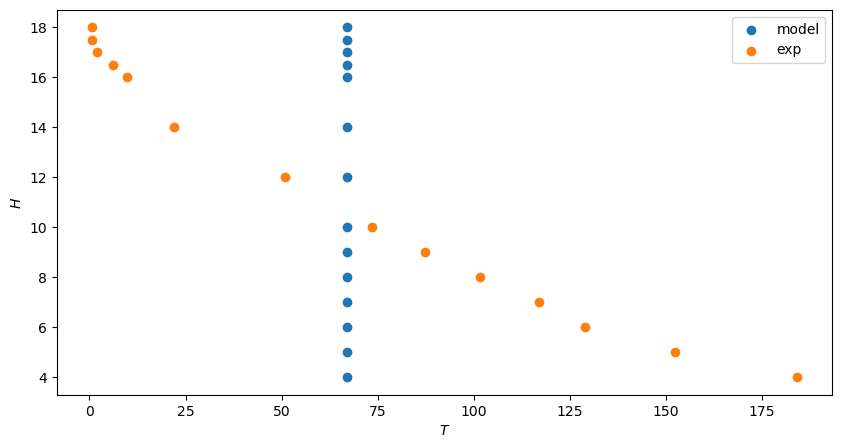

In [49]:
H_opt = compute_Hc(T, Tc_opt, H0_opt)

plt.figure(figsize=(10, 5))
plt.scatter(H_opt, T, label="model")

plt.scatter(H, T, label="exp")
plt.xlabel(r"$T$")
plt.ylabel(r"$H$")
plt.legend()
plt.show()

$
H_{c1} = \dfrac{he}{2m} \left( 1 + 2\int\limits_{\Delta} ^{\inf} dE ~ \dfrac{\partial f(E)}{\partial E} ~ \dfrac{E}{\sqrt{E^2 - \Delta_0^2 \tanh^2{\dfrac{T_c}{T} \sqrt{\dfrac{2}{3} \left(\dfrac{T_c}{T}-1 \right)}}}} \right) \cdot \ln{\left (\dfrac{\sqrt{m} \Delta_0 \tanh{\dfrac{T_c}{T} \sqrt{\dfrac{2}{3} \left(\dfrac{T_c}{T} -1 \right)}}}{\sqrt{4 \pi e^2} \hbar v_F \cdot \sqrt{1 + 2\int\limits_{\Delta} ^{\inf} dE ~ \dfrac{\partial f(E)}{\partial E} ~ \dfrac{E}{\sqrt{E^2 - \Delta_0^2 \tanh^2{\dfrac{T_c}{T} \sqrt{\dfrac{2}{3} \left(\dfrac{T_c}{T}-1 \right)}}}}}} \right)}
$

$f(E) = \dfrac{1}{\exp{\left(\dfrac{E}{kT}\right)}+1},~ \dfrac{\partial f}{\partial E} = - \dfrac{\exp{\left (\dfrac{E}{kT}\right)}}{kT \exp{\left(\dfrac{2E}{kT}\right) + 2kT \exp{\left(\dfrac{E}{kT}\right) + kT}}}$

$
\Delta = \Delta_0 \cdot \tanh{(\dfrac{T_c}{T} \sqrt{\dfrac{2}{3}(\dfrac{T_c}{T}-1)})} 
$

In [ ]:
k_B = 1
hbar = 1
h = 1
e = 1
m = 1
v_F = 1

In [ ]:
def safe_sqrt(x):
    return np.sqrt(np.maximum(x, 1e-5))


def Delta(T, T_c, Delta_0):
    delta_val = Delta_0 * \
        np.tanh((T_c / T) * safe_sqrt((2 / 3) * (T_c / T - 1)))
    return delta_val


def df_dE(E, T):
    if E / (k_B * T) > 500:
        return 0

    exp_E = np.exp(E / (k_B * T))
    log_exp_E = np.log(exp_E + 1)

    denominator = k_B * T * (exp_E**2 + 2 * exp_E + 1)
    return -exp_E / denominator


def integral_part(T, T_c, Delta_0):
    Delta_T = Delta(T, T_c, Delta_0)

    if np.any(Delta_T <= 0) or np.any(np.isnan(Delta_T)):
        return np.nan

    def integrand(E):
        sqrt_val = np.sqrt(np.maximum(E**2 - Delta_T**2, 1e-5))
        return df_dE(E, T) * E / sqrt_val

    result, _ = spi.quad(integrand, Delta_T, np.inf,
                         limit=100, epsabs=1e-6, epsrel=1e-6)
    return 1 + 2 * result


def H_c1_model(T, T_c, Delta_0):
    D_T = Delta(T, T_c, Delta_0)
    I_T = integral_part(T, T_c, Delta_0)

    if np.isnan(D_T) or np.isnan(I_T) or I_T <= 0:
        return np.nan

    log_argument = np.sqrt(m) * D_T * np.tanh((T_c / T) * safe_sqrt((2 / 3) * (T_c / T - 1))) / \
        (np.sqrt(4 * np.pi * e**2) * hbar * v_F * np.sqrt(I_T))

    if log_argument <= 0:
        return np.nan

    return (h * e / (2 * m)) * I_T * np.log(log_argument)


def error_function(params, T_values, H_c1_values):
    T_c, Delta_0 = params
    errors = []

    print(f"Параметры: T_c = {T_c}, Delta_0 = {Delta_0}")

    for T, H_exp in zip(T_values, H_c1_values):
        H_model = H_c1_model(T, T_c, Delta_0)
        if not np.isnan(H_model):
            error = (H_exp - H_model)**2
            print(
                f"T = {T}, H_exp = {H_exp}, H_model = {H_model}, ошибка = {error}")
            errors.append(error)

    mean_error = np.mean(errors)
    print(f"Средняя ошибка: {mean_error}")
    return mean_error

In [ ]:
initial_params = [350, 10]
bounds = [
    (0, 1e9),
    (0, 1e9),
]

In [ ]:
initial_guess = [350, 10]
result = minimize(error_function, initial_guess, args=(T, H),
                  method='Powell', options={'disp': True})


if result.success:
    T_c_opt, Delta_0_opt = result.x
    print(
        f"Оптимальные параметры: T_c = {T_c_opt:.3f} K, Delta_0 = {Delta_0_opt:.3e} eV")
else:
    print("Оптимизация не удалась")

Параметры: T_c = 350.0, Delta_0 = 10.0
T = 4.0, H_exp = 184.00962333333334, H_model = 0.41352280220449283, ошибка = 33707.52813023637
T = 5.0, H_exp = 152.30069, H_model = 0.35742096609745977, ошибка = 23086.757004708885
T = 6.0, H_exp = 128.86061333333333, H_model = 0.30700490368508704, ошибка = 16526.03024028333
T = 7.0, H_exp = 116.83617000000001, H_model = 0.2641137346685845, ошибка = 13589.044301927595
T = 8.0, H_exp = 101.70071666666668, H_model = 0.2284173426975102, ошибка = 10296.627530093194
T = 9.0, H_exp = 87.26121333333333, H_model = 0.19889570691244546, ошибка = 7579.847150483795
T = 10.0, H_exp = 73.42453333333333, H_model = 0.1744478975215133, ошибка = 5365.57501635373
T = 12.0, H_exp = 50.897416666666665, H_model = 0.13704827766726607, ошибка = 2576.614998986929
T = 14.0, H_exp = 21.98146, H_model = 0.11041269775376497, ошибка = 478.3427100970922
T = 16.0, H_exp = 9.68148, H_model = 0.09087836839821078, ошибка = 91.9796396560829
T = 16.5, H_exp = 6.12189, H_model = 0.08

/var/folders/1m/dzf4t3l52bb2l28wrhcwc_dr0000gn/T/ipykernel_5038/1016272186.py:16: RuntimeWarning: overflow encountered in scalar power
  denominator = k_B * T * (exp_E**2 + 2 * exp_E + 1)
/var/folders/1m/dzf4t3l52bb2l28wrhcwc_dr0000gn/T/ipykernel_5038/1016272186.py:16: RuntimeWarning: overflow encountered in scalar multiply
  denominator = k_B * T * (exp_E**2 + 2 * exp_E + 1)


T = 17.5, H_exp = 0.7199366666666667, H_model = 53.23971958320604, ошибка = 2758.3275976004206
T = 18.0, H_exp = 0.7189466666666666, H_model = 53.23971958320604, ошибка = 2758.4315877506956
Средняя ошибка: 3845.0378328432953
Параметры: T_c = 350.0, Delta_0 = 8.723511553242542e+46
T = 4.0, H_exp = 184.00962333333334, H_model = 53.40971200607998, ошибка = 17056.33683868644
T = 5.0, H_exp = 152.30069, H_model = 53.40971200607998, ошибка = 9779.425528593973
T = 6.0, H_exp = 128.86061333333333, H_model = 53.40971200607998, ошибка = 5692.838511094921
T = 7.0, H_exp = 116.83617000000001, H_model = 53.40971200607998, ошибка = 4022.915573654502
T = 8.0, H_exp = 101.70071666666668, H_model = 53.40971200607998, ошибка = 2332.0211311288062
T = 9.0, H_exp = 87.26121333333333, H_model = 53.40971200607998, ошибка = 1145.9241421090355
T = 10.0, H_exp = 73.42453333333333, H_model = 53.40971200607998, ошибка = 400.5930727618756
T = 12.0, H_exp = 50.897416666666665, H_model = 53.40971200607998, ошибка = 

In [201]:
differential_evolution(error_function, bounds, args=(T, H))

Параметры: T_c = 252238480.19242874, Delta_0 = 829378428.4096382
T = 4.0, H_exp = 184.00962333333334, H_model = 9.635337486642163, ошибка = 30406.391564543563
T = 5.0, H_exp = 152.30069, H_model = 9.635337486642163, ошибка = 20353.40280776066
T = 6.0, H_exp = 128.86061333333333, H_model = 9.635337486642163, ошибка = 14214.666400719601
T = 7.0, H_exp = 116.83617000000001, H_model = 9.635337486642163, ошибка = 11492.018491557003
T = 8.0, H_exp = 101.70071666666668, H_model = 9.635337486642163, ошибка = 8476.034043561693
T = 9.0, H_exp = 87.26121333333333, H_model = 9.635337486642163, ошибка = 6025.776600965912
T = 10.0, H_exp = 73.42453333333333, H_model = 9.635337486642163, ошибка = 4069.061506767521
T = 12.0, H_exp = 50.897416666666665, H_model = 9.635337486642163, ошибка = 1702.5591782586114
T = 14.0, H_exp = 21.98146, H_model = 9.635337486642163, ошибка = 152.4267411148412
T = 16.0, H_exp = 9.68148, H_model = 9.635337486642163, ошибка = 0.002129131538978231
T = 16.5, H_exp = 6.12189,

             message: Optimization terminated successfully.
             success: True
                 fun: 6928.11189490036
                   x: [ 4.541e+07  9.732e+08]
                 nit: 1
                nfev: 63
          population: [[ 4.541e+07  9.732e+08]
                       [ 3.254e+08  6.819e+08]
                       ...
                       [ 7.802e+08  9.444e+08]
                       [ 3.314e+08  5.729e+08]]
 population_energies: [ 6.928e+03  6.948e+03 ...  6.930e+03  6.958e+03]

In [ ]:
result = spo.minimize(error_function,  initial_params, args=(
    T, H), bounds=bounds, method="Nelder-Mead")

Параметры: T_c = 350.0, Delta_0 = 10.0
T = 4.0, H_exp = 184.00962333333334, H_model = 0.41352280220449283, ошибка = 33707.52813023637
T = 5.0, H_exp = 152.30069, H_model = 0.35742096609745977, ошибка = 23086.757004708885
T = 6.0, H_exp = 128.86061333333333, H_model = 0.30700490368508704, ошибка = 16526.03024028333
T = 7.0, H_exp = 116.83617000000001, H_model = 0.2641137346685845, ошибка = 13589.044301927595
T = 8.0, H_exp = 101.70071666666668, H_model = 0.2284173426975102, ошибка = 10296.627530093194
T = 9.0, H_exp = 87.26121333333333, H_model = 0.19889570691244546, ошибка = 7579.847150483795
T = 10.0, H_exp = 73.42453333333333, H_model = 0.1744478975215133, ошибка = 5365.57501635373
T = 12.0, H_exp = 50.897416666666665, H_model = 0.13704827766726607, ошибка = 2576.614998986929
T = 14.0, H_exp = 21.98146, H_model = 0.11041269775376497, ошибка = 478.3427100970922
T = 16.0, H_exp = 9.68148, H_model = 0.09087836839821078, ошибка = 91.9796396560829
T = 16.5, H_exp = 6.12189, H_model = 0.08

/var/folders/1m/dzf4t3l52bb2l28wrhcwc_dr0000gn/T/ipykernel_5038/1016272186.py:16: RuntimeWarning: overflow encountered in scalar power
  denominator = k_B * T * (exp_E**2 + 2 * exp_E + 1)


T = 17.5, H_exp = 0.7199366666666667, H_model = 0.4050315139472566, ошибка = 0.09916525520923497
T = 18.0, H_exp = 0.7189466666666666, H_model = 0.3731814076132509, ошибка = 0.11955361436827568
Средняя ошибка: 8005.959272500477
Параметры: T_c = 13.125, Delta_0 = 30.5
T = 4.0, H_exp = 184.00962333333334, H_model = 1.0725625655260778, ошибка = 33465.968202364405
T = 5.0, H_exp = 152.30069, H_model = 1.0550419705769445, ошибка = 22875.246047840123
T = 6.0, H_exp = 128.86061333333333, H_model = 1.0000025624647568, ошибка = 16348.335786699554
T = 7.0, H_exp = 116.83617000000001, H_model = 0.8839071776703292, ошибка = 13444.92725361862
T = 8.0, H_exp = 101.70071666666668, H_model = 0.7020098311608169, ошибка = 10200.738782444458
T = 9.0, H_exp = 87.26121333333333, H_model = 0.4821314315385135, ошибка = 7530.609055718412
T = 10.0, H_exp = 73.42453333333333, H_model = 0.2753045784428409, ошибка = 5350.809667435297
T = 12.0, H_exp = 50.897416666666665, H_model = 0.03231454073394929, ошибка = 25

/var/folders/1m/dzf4t3l52bb2l28wrhcwc_dr0000gn/T/ipykernel_5038/1016272186.py:16: RuntimeWarning: overflow encountered in scalar multiply
  denominator = k_B * T * (exp_E**2 + 2 * exp_E + 1)


In [ ]:
if result.success:
    T_c_opt, Delta_0_opt = result.x
    print(
        f"Оптимальные параметры: T_c = {T_c_opt:.3f} K, Delta_0 = {Delta_0_opt:.3e} eV")
else:
    print("Оптимизация не удалась")

Оптимальные параметры: T_c = 6293802.588 K, Delta_0 = 1.000e+09 eV


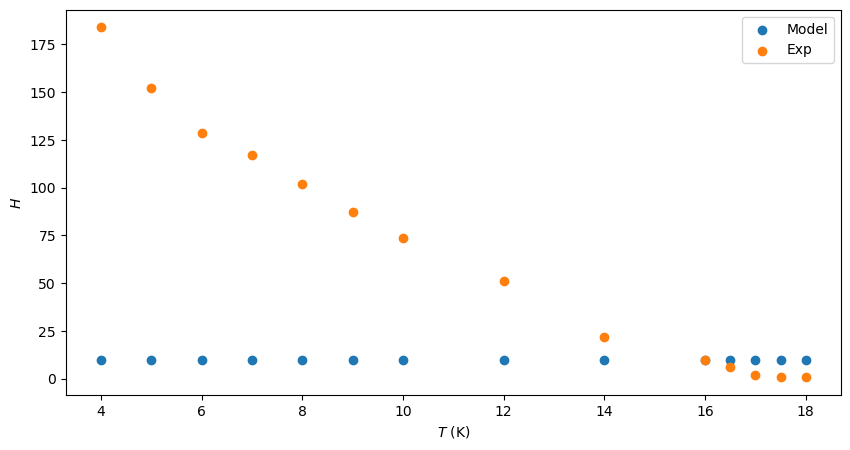

In [ ]:
H_model_values = [H_c1_model(t, T_c_opt, Delta_0_opt) for t in T]

plt.figure(figsize=(10, 5))
plt.scatter(T, H_model_values, label="Model")
plt.scatter(T, H, label="Exp")
plt.xlabel(r"$T$ (K)")
plt.ylabel(r"$H$")
plt.legend()
plt.show()